# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [1]:
# Load the libraries as required.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import shap
import pickle
import warnings
warnings.filterwarnings('ignore')

/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set random state for repoducibility
RANDOM_STATE = 42
# Set the style for seaborn
sns.set(style="whitegrid")

In [3]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))

print("Dataset Info:")
fires_dt.info()

print("\nDataset Shape:", fires_dt.shape)
print("\nFirst 5 Rows of the Dataset:")
print(fires_dt.head())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB

Dataset Shape: (517, 13)

First 5 Rows of the Dataset:
   coord_x  coord_y month  day  ffmc   dmc     dc  isi  temp  rh  wind  rain  \
0        7        5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   
1        7        4   oct  tue  

In [4]:
print("\nStatistics:")
print(fires_dt.describe())
# Check for missing values
print("\nMissing Values:")
print(fires_dt.isnull().sum())


Statistics:
          coord_x     coord_y        ffmc         dmc          dc         isi  \
count  517.000000  517.000000  517.000000  517.000000  517.000000  517.000000   
mean     4.669246    4.299807   90.644681  110.872340  547.940039    9.021663   
std      2.313778    1.229900    5.520111   64.046482  248.066192    4.559477   
min      1.000000    2.000000   18.700000    1.100000    7.900000    0.000000   
25%      3.000000    4.000000   90.200000   68.600000  437.700000    6.500000   
50%      4.000000    4.000000   91.600000  108.300000  664.200000    8.400000   
75%      7.000000    5.000000   92.900000  142.400000  713.900000   10.800000   
max      9.000000    9.000000   96.200000  291.300000  860.600000   56.100000   

             temp          rh        wind        rain         area  
count  517.000000  517.000000  517.000000  517.000000   517.000000  
mean    18.889168   44.288201    4.017602    0.021663    12.847292  
std      5.806625   16.317469    1.791653    0.295

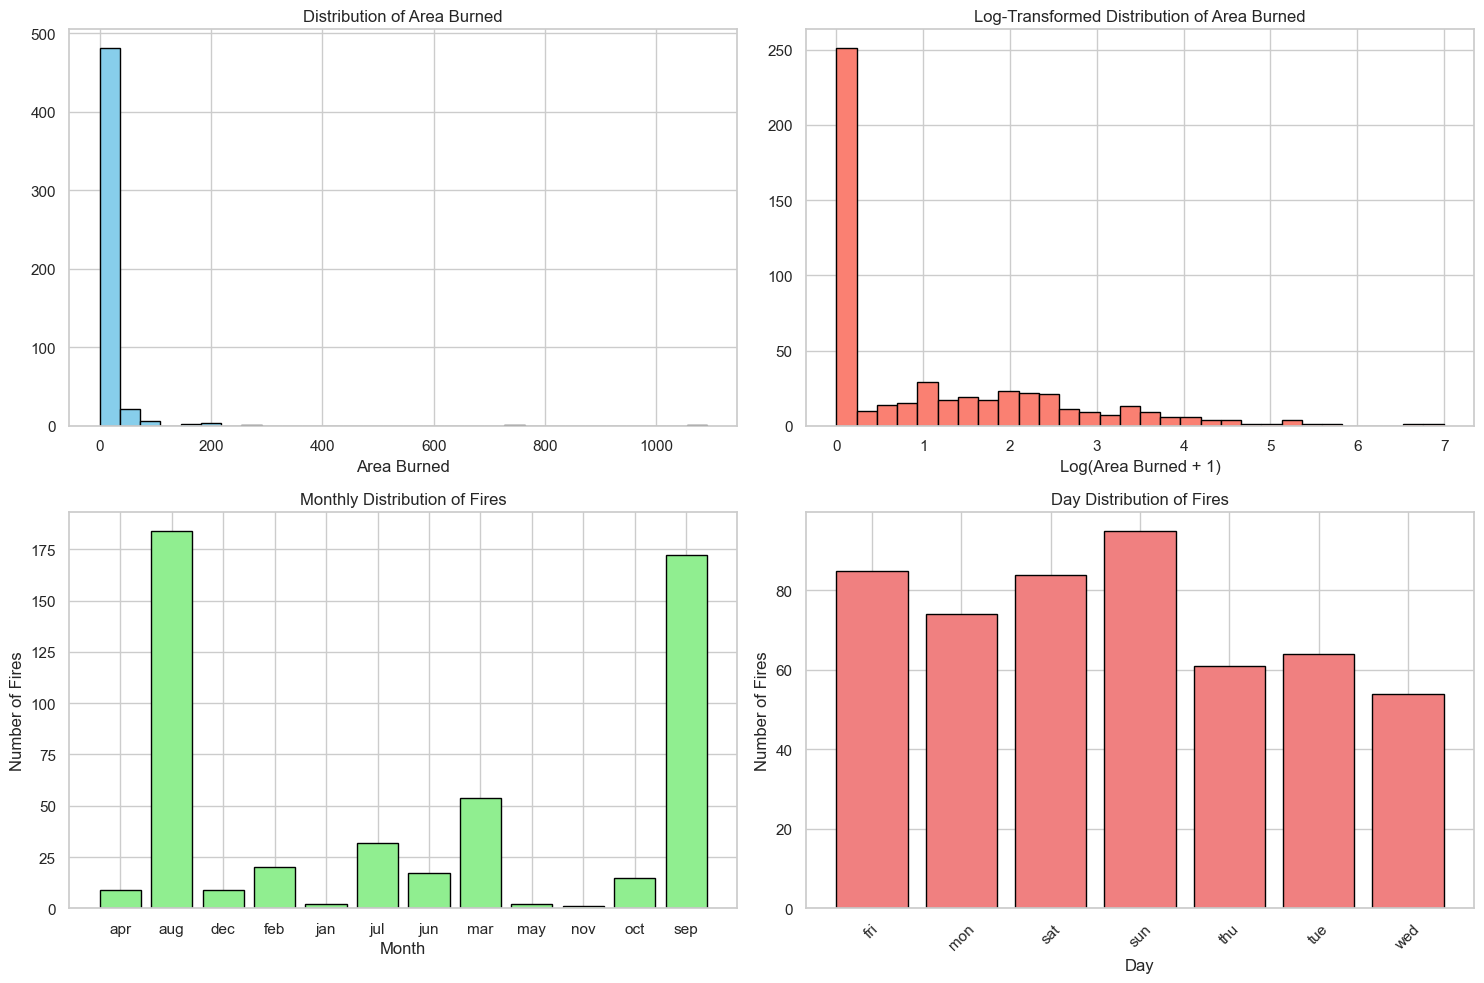

In [5]:
# EDA
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Distribution of target variable
axes[0,0].hist(fires_dt['area'], bins=30, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribution of Area Burned')
axes[0,0].set_xlabel('Area Burned')

# Log-transformed distribution of target variable
axes[0,1].hist(np.log1p(fires_dt['area']), bins=30, color='salmon', edgecolor='black')
axes[0,1].set_title('Log-Transformed Distribution of Area Burned')
axes[0,1].set_xlabel('Log(Area Burned + 1)')

# Monthly distribution of fires
month_counts = fires_dt['month'].value_counts().sort_index()
axes[1,0].bar(month_counts.index, month_counts.values, color='lightgreen', edgecolor='black')
axes[1,0].set_title('Monthly Distribution of Fires')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Number of Fires')

# Day distribution
day_counts = fires_dt['day'].value_counts().sort_index()
axes[1,1].bar(day_counts.index, day_counts.values, color='lightcoral', edgecolor='black')
axes[1,1].set_title('Day Distribution of Fires')
axes[1,1].set_xlabel('Day')
axes[1,1].set_ylabel('Number of Fires')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

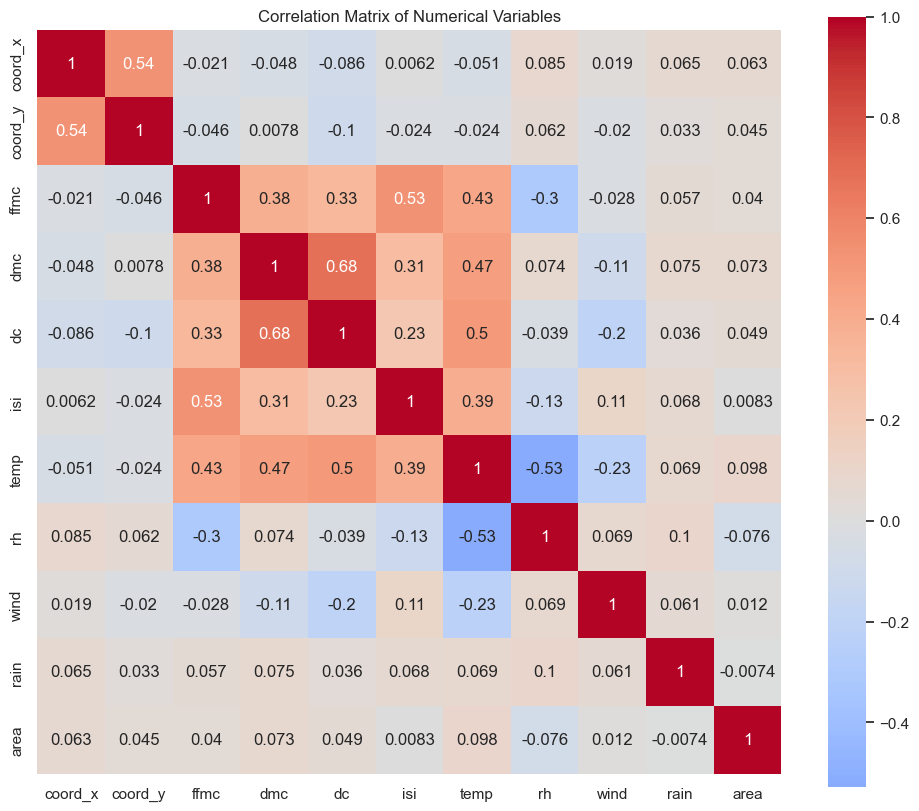

In [6]:
# Correlation matrix of numerical variables
numerical_cols = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area']
corr_matrix = fires_dt[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

# Get X and Y

Create the features data frame and target data.

In [7]:
# Create the features data frame
X = fires_dt.drop('area', axis=1)
y = fires_dt['area']

print("Feature shape:", X.shape)
print("Target shape:", y.shape)

# Since the target variable is highlly skewed, we will apply a log transformation.
y_transformed = np.log1p(y)

print("\nTarget variable statistics:")
print("Original target - Mean:", y.mean(), "Std:", y.std())
print("Transformed target - Mean:", y_transformed.mean(), "Std:", y_transformed.std())

Feature shape: (517, 12)
Target shape: (517,)

Target variable statistics:
Original target - Mean: 12.847292069632493 Std: 63.65581846794089
Transformed target - Mean: 1.1110257652960878 Std: 1.398435955883445


In [8]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_transformed, test_size=0.2, random_state=RANDOM_STATE
)

print("\nData split completed:")
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

# Identify numerical and categorical columns
numerical_features = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
categorical_features = ['month', 'day']

print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)


Data split completed:
Training set shape: (413, 12)
Test set shape: (104, 12)
Numerical features: ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
Categorical features: ['month', 'day']


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [9]:
preproc1 = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
], remainder='drop')

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [10]:
preproc2 = ColumnTransformer([
    ('num', Pipeline([
        ('power', PowerTransformer(method='yeo-johnson')),
        ('scaler', StandardScaler())
    ]), numerical_features),
    ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
], remainder='drop')

print("Preprocessors created successfully!")

Preprocessors created successfully!


## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [11]:
# Pipeline A = preproc1 + baseline

pipeline_A = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', Ridge(random_state=RANDOM_STATE))
])

In [12]:
# Pipeline B = preproc2 + baseline
pipeline_B = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', Ridge(random_state=RANDOM_STATE))
])

In [13]:
# Pipeline C = preproc1 + advanced model
pipeline_C = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

In [15]:
# Pipeline D = preproc2 + advanced model
pipeline_D = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])
    

In [16]:
pipelines = {
    'Pipeline A (Simple + Ridge)': pipeline_A,
    'Pipeline B (Transform + Ridge)': pipeline_B,
    'Pipeline C (Simple + RF)': pipeline_C,
    'Pipeline D (Transform + RF)': pipeline_D
}

print("Pipelines created successfully!")

Pipelines created successfully!


# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [17]:
param_grids = {
    'Pipeline A (Simple + Ridge)': {
        'regressor__alpha': [0.1, 1.0, 10.0, 100.0],
        'regressor__solver': ['auto', 'svd', 'cholesky', 'lsqr']
    },
    'Pipeline B (Transform + Ridge)': {
        'regressor__alpha': [0.1, 1.0, 10.0, 100.0],
        'regressor__solver': ['auto', 'svd', 'cholesky', 'lsqr']
    },
    'Pipeline C (Simple + RF)': {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [5, 10, 15, None],
        'regressor__min_samples_split': [2, 5, 10]
    },
    'Pipeline D (Transform + RF)': {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [5, 10, 15, None],
        'regressor__min_samples_split': [2, 5, 10]
    }
}

In [18]:
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

In [19]:
# Perform GridSearch

best_models = {}
cv_results = {}

print("Starting hyperparameter tuning...")

for name, pipeline in pipelines.items():
    print(f"\nTuning {name}...")
    
    grid_search = GridSearchCV(
        pipeline,
        param_grids[name],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    best_models[name] = grid_search.best_estimator_
    cv_results[name] = {
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_,
        'cv_results': grid_search.cv_results_
    }
    
    print(f"Best CV Score: {grid_search.best_score_:.4f}")
    print(f"Best Parameters: {grid_search.best_params_}")

print("\nHyperparameter tuning completed!")

Starting hyperparameter tuning...

Tuning Pipeline A (Simple + Ridge)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/minicon

Best CV Score: -2.1219
Best Parameters: {'regressor__alpha': 100.0, 'regressor__solver': 'lsqr'}

Tuning Pipeline B (Transform + Ridge)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/minicon

Best CV Score: -1.9178
Best Parameters: {'regressor__alpha': 100.0, 'regressor__solver': 'lsqr'}

Tuning Pipeline C (Simple + RF)...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/minicon

Best CV Score: -2.0274
Best Parameters: {'regressor__max_depth': 5, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 200}

Tuning Pipeline D (Transform + RF)...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/minicon

Best CV Score: -2.0271
Best Parameters: {'regressor__max_depth': 5, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 200}

Hyperparameter tuning completed!


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [20]:
print(f"Best CV Score: {grid_search.best_score_:.4f}")
print(f"Best Parameters: {grid_search.best_params_}")

Best CV Score: -2.0271
Best Parameters: {'regressor__max_depth': 5, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 200}


# Evaluate

+ Which model has the best performance?

In [21]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Evaluate model performance using multiple metrics"""
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Metrics
    metrics = {
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Test MAE': mean_absolute_error(y_test, y_test_pred),
        'Train R²': r2_score(y_train, y_train_pred),
        'Test R²': r2_score(y_test, y_test_pred),
        'Train Explained Variance': explained_variance_score(y_train, y_train_pred),
        'Test Explained Variance': explained_variance_score(y_test, y_test_pred)
    }
    
    return metrics, y_test_pred

In [22]:
# Evaluate all models
evaluation_results = {}

print("Evaluating all models...")
for name, model in best_models.items():
    metrics, predictions = evaluate_model(model, X_train, X_test, y_train, y_test)
    evaluation_results[name] = metrics
    evaluation_results[name]['predictions'] = predictions

# Create results DataFrame for better visualization
results_df = pd.DataFrame(evaluation_results).T

print("\nModel Evaluation Results:")
print(results_df.drop('predictions', axis=1).round(4))

# Identify best model based on Test RMSE (lower is better)
best_model_name = results_df['Test RMSE'].idxmin()
best_model = best_models[best_model_name]

print(f"\nBest performing model: {best_model_name}")
print(f"Test RMSE: {results_df.loc[best_model_name, 'Test RMSE']:.4f}")
print(f"Test R²: {results_df.loc[best_model_name, 'Test R²']:.4f}")

Evaluating all models...

Model Evaluation Results:
                               Train RMSE Test RMSE Train MAE  Test MAE  \
Pipeline A (Simple + Ridge)      1.349463  1.473033  1.118835  1.192521   
Pipeline B (Transform + Ridge)   1.347972  1.469072  1.117747  1.192552   
Pipeline C (Simple + RF)          1.15224   1.47482  0.950556  1.184785   
Pipeline D (Transform + RF)       1.15238  1.474139  0.950587  1.184021   

                                Train R²   Test R² Train Explained Variance  \
Pipeline A (Simple + Ridge)     0.036285  0.012756                 0.036285   
Pipeline B (Transform + Ridge)  0.038413  0.018058                 0.038413   
Pipeline C (Simple + RF)        0.297392  0.010359                  0.29744   
Pipeline D (Transform + RF)     0.297222  0.011273                 0.297269   

                               Test Explained Variance  
Pipeline A (Simple + Ridge)                    0.01511  
Pipeline B (Transform + Ridge)                0.020488  
Pipel

# Export

+ Save the best performing model to a pickle file.

In [23]:
# Saving the best model
with open('best_forest_fire_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)
print(f"\nBest model ({best_model_name}) saved as 'best_forest_fire_model.pkl'")  


Best model (Pipeline B (Transform + Ridge)) saved as 'best_forest_fire_model.pkl'


In [28]:
import numpy as np
np.bool = np.bool_  # Fix for deprecated np.bool used in shap
import shap


In [37]:
# For tree-based models, we can use TreeExplainers
# For linear models, we can use LinearExplainers
if 'RF' in best_model_name:
    # Get the trained preprocessor and regressor
    preprocessor = best_model.named_steps['preprocessing']
    regressor = best_model.named_steps['regressor']

    # Transform the data
    X_train_transformed = preprocessor.transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)

    # Create SHAP explainer
    explainer = shap.TreeExplainer(regressor)
    shap_values = explainer.shap_values(X_test_transformed)

    # Get feature names after preprocessing
    feature_names = (numerical_features + 
                     list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)))

else:
    preprocessor = best_model.named_steps['preprocessing']
    regressor = best_model.named_steps['regressor']
    
    X_train_transformed = preprocessor.transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)

    explainer = shap.LinearExplainer(regressor, X_train_transformed)
    shap_values = explainer.shap_values(X_test_transformed)

    # Get feature names after preprocessing
    feature_names = (numerical_features + 
                     list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)))


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?


Local Explanation for Test Sample 0:
Actual value: 0.0000
Predicted value: 1.1087


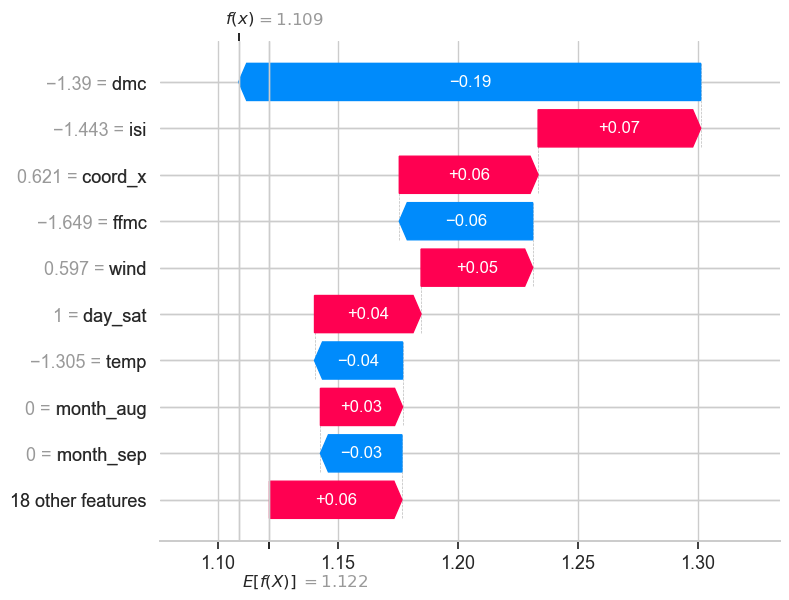

In [38]:
sample_idx = 0
sample_observation = X_test_transformed[sample_idx:sample_idx+1]

print(f"\nLocal Explanation for Test Sample {sample_idx}:")
print(f"Actual value: {y_test.iloc[sample_idx]:.4f}")
print(f"Predicted value: {evaluation_results[best_model_name]['predictions'][sample_idx]:.4f}")
# Plot local explanation
shap.plots.waterfall(shap.Explanation(
    values=shap_values[sample_idx], 
    base_values=explainer.expected_value, 
    data=X_test_transformed[sample_idx],
    feature_names=feature_names
), show=True) 

## Inference of the above waterfall plot

Base Value E[f(x)] = 1.064: This is the starting point. It's the average predicted log(area + 1) for all fires. If you knew nothing else about this specific fire, you'd guess 1.064.

Bars: Each bar represents a feature's contribution. Blue bars (negative) push the prediction down, making the model predict a smaller fire. Red bars (positive) push the prediction up, making the model predict a larger fire.

Feature Values: The gray numbers on the left (e.g., -1.39 = dmc) are the actual (scaled) values for this specific fire. A value of -1.39 means this fire had a below-average DMC.

Final Prediction f(x) = 1.109: This is the final output of the model for this specific fire, after adding up all the red and blue contributions to the base value.

Biggest Factor: The most influential factor was the DMC (Drought Moisture Code). Its value was low (-1.39), which had a strong negative impact (-0.16), significantly pushing the model to predict a smaller fire. This makes intuitive sense: less drought means less dry fuel.

Overall: The negative factors (like low dmc) and positive factors (like high wind and location coord_x) roughly balanced out, leading to a final prediction (1.109) that is only slightly higher than the average (1.064).

*(Answer here.)*

## Explanations

Performance Metric choise RMSE
RMSE was chosen primarily because its a prediction metric(not correlation), it penalizes large error more than MAE, it is in the same units as target variable and its inperpretable for forest fire aea predition. Test RMSE: 1.4691. This means, on average, the model's predictions are off by about 1.4691 units (of burned area)

Test Rsquared
Best Rsquared was 0.081. This indicates that the model explains about 1.81% of variance in the burned area int he test set. This is a very low value(close to 0), this suggests the model is not performing better than random guess interms of explaining data variability. low R-squared is not a failure. It's an accurate measurement of how difficult this specific prediction task is with this specific dataset. This proves that weather conditions alone are not enough to predict forest fire size with high accuracy.

From the waterfall plot, it is clear that isi is cofusing the model. The weak and confusing singnals overwhelm the good features. So the model cannot reliabily explain explain the variance in the data.

Best Performing Model
Based on Test RMSE PipelineB(Trnasform+ Ridge) was identified as the best performing model among the four. It achieved the lowest RMSE value(1.4691)

## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.